In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam, Adam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy
import ntpath

import tensorflow as tf

K.clear_session()
K.set_image_dim_ordering('tf')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)




def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    return loss

def unet_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true,y_pred) - K.log(jaccard_coef(y_true,y_pred))
    return loss

In [3]:
def preprocessmask(gray):
    ret, gray = cv2.threshold(gray, 200, 255,0)
    imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    #x,y,w,h = cv2.boundingRect(largest_areas[-1])
    mask = np.zeros((512,512),dtype= np.uint8)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    return mask

In [4]:
model = load_model('accunetnew.h5', custom_objects={'unet_loss': unet_loss})

In [5]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """    
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [ ]:
import glob
import ntpath
count= ""
image_size = 512
orig_path = "/home/ubuntu/research/train/btrain/*"
output_overlay_path = "/home/ubuntu/research/train/overlayfour/"
orig = glob.glob(orig_path)
for fl in orig:
    count = fl
    orig_images= cv2.imread(fl)
    orig_images = cv2.resize(orig_images, (512, 512))
    image = np.expand_dims(orig_images, axis=0)
    mpo = model.predict(image)
    a = np.uint8(mpo*255)
    gray = a.reshape(512,512)
    k=preprocessmask(gray)
    final_overlay = mask_overlay(orig_images, (k > 0.5).astype(np.uint8))
    basenm = ntpath.basename(fl)
    nm_output_mask = output_overlay_path+basenm
    cv2.imwrite(nm_output_mask,final_overlay)

In [ ]:
largest_areas=[]
def preprocessmask(gray):
    global largest_areas
    ret, gray = cv2.threshold(gray, 250, 255,0)
    imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    #x,y,w,h = cv2.boundingRect(largest_areas[-1])
    mask = np.zeros((512,512),dtype= np.uint8)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    return mask

In [ ]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/3812.png")
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = model.predict(image)
a = np.uint8(mpo*255)
gray = a.reshape(512,512)
ret, gray = cv2.threshold(gray, 140, 255,0)
imageha, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
plt.imshow(gray)
plt.show()

In [ ]:
plt.imshow(final_overlay)
plt.show()

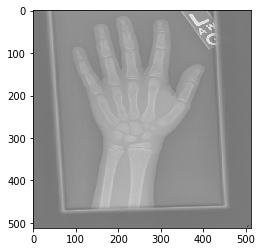

In [12]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/1399.png")
orig_images = cv2.resize(orig_images, (512, 512))
pico= cv2.imread("/home/ubuntu/research/train/btrain/1434.png")
plt.imshow( cv2.resize(pico, (orig_images.shape[1],orig_images.shape[0])))
plt.show()

In [ ]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/1399.png")
orig_images = cv2.resize(orig_images, (512, 512))
plt.imshow(orig_images)
plt.show()

(1347, 949, 3)


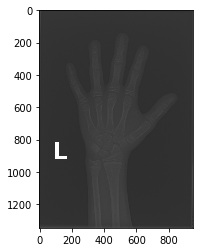

True

In [9]:
orig_images= cv2.imread("/home/ubuntu/research/train/btrain/2543.png")
print(orig_images.shape)
#orig_images = cv2.resize(orig_images, (512, 512))
plt.imshow(orig_images)
plt.show()
cv2.imwrite("outputforml/2.png",orig_images)

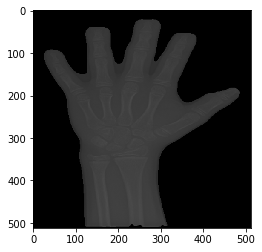

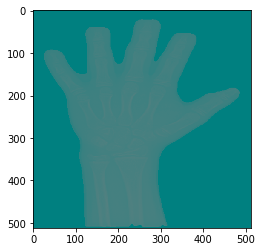

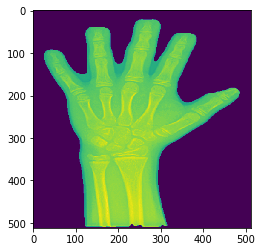

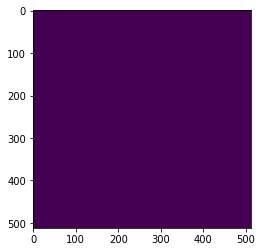

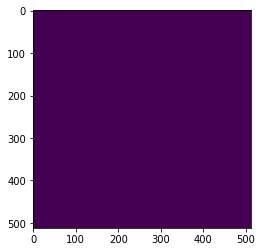

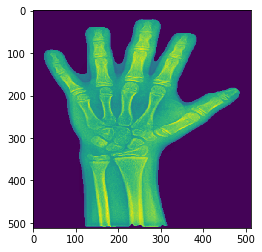

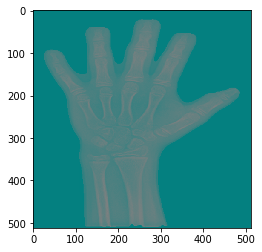

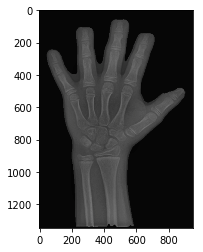

In [13]:
orig_images = cv2.imread('train/btrain/2543.png')
newimage = orig_images
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = model.predict(image)
a = np.uint8(mpo*255)
a = a.reshape(512,512,1)

ret, gray = cv2.threshold(a, 200, 255,0)
image, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_areas = sorted(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(largest_areas[-1])
mask = np.zeros((512,512),dtype= np.uint8)
cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
image = cv2.bitwise_and(orig_images, orig_images, mask=mask)
roi=image[y-20:y+h+20,x-20:x+w+20]
roi=cv2.resize(roi,(512,512))
plt.imshow(roi)
plt.show()

lab= cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
plt.imshow(lab)
plt.show()
cv2.imwrite("outputforml/2_lab.png",roi)
#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)
plt.show()
cv2.imwrite("outputforml/2_l.png",l)

plt.imshow(a)
plt.show()

plt.imshow(b)

plt.show()
#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
cv2.imwrite("outputforml/2_processed.png",cl)
plt.imshow( cl)
plt.show()
#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)
plt.show()
#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
final = cv2.resize(final, (newimage.shape[1],newimage.shape[0]))
cv2.imwrite("outputforml/2_final.png",final)

plt.imshow(final)
plt.show()

In [ ]:
orig_images = cv2.imread('train/btrain/1399.png')
orig_images.shape

In [ ]:
final= cv2.resize(final, (945, 1293))
plt.imshow(final)
plt.show()

In [ ]:
orig_images = cv2.imread('train/btrain/5463.png')
plt.imshow(orig_images)
plt.show()

In [ ]:
orig_images = cv2.imread('train/btrain/5463.png')
orig_images = cv2.resize(orig_images, (512, 512))
image = np.expand_dims(orig_images, axis=0)
mpo = model.predict(image)
a = np.uint8(mpo*255)
a = a.reshape(512,512)
plt.imshow(a)

In [ ]:
!mkdir outputforml

In [ ]:
!ls